In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from typing import List, Literal

import mediapy as media
import numpy as np
import torch
import tqdm
from config_tools.common import get_typed_root_config
from einops import rearrange
from hydra import compose, initialize

# import ipython display
from IPython import display
from jacobian.dataset.pusher_dataset import Trajectory
from jacobian.utils.io import load_gzip_file, save_gzip_file
from mujoco_sim.env.push_env import PushEnv, PushEnvCfg
from raft_wrapper import InputPadder, RaftWrapper
from raft_wrapper.raft import resize_batched_flow, resize_batched_frames
from torchvision.utils import flow_to_image

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/scene-rep-robot/miniconda3/envs/neural-jacobian-field-public/lib/python3.10/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)
[robosuite WARNING] Could not import robosuite_models. Some robots may not be available. If you want to use these robots, please install robosuite_models from source (https://github.com/ARISE-Initiative/robosuite_models) or through pip install. (__init__.py:30)
[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not be able to use the default IK controller setting for GR1 robot. (__init__.py:40)


WARNING! gymnasium is not installed. We will try to use openai gym instead.


# Tutorial 1: Training Jacobian Fields in 2D Pusher Environment.

Author: [Sizhe Lester Li](https://sizhe-li.github.io/), PhD Student, MIT CSAIL

## A. Learning Outcomes
We will use a simple "coke can pusher" robot to illustrate the idea of Jacobian Fields. Learning from just two trajectories -- "move-right" and "move-down" -- our Jacobian fields will be able to predict the full range of robot motions that are unseen during learning. 

As illustrated in the figure below, Jacobian Fields can predict the dynamics of unseen commands as enabled by the nature of linearity.

By the end of the tutorial, you will understand
1. The self-supervised nature of observation data required for training Jacobian fields
2. How to train Jacobian Fields in pytorch
3. How to use the learned Jacobian Fields to command the robot pusher 
4. How to visualize the anatomy of Jacobians


## B. Pusher Environment Description

The environment contains a spherical robotic pusher. The robot can move freely in 2D space and is steered by a 2D velocity command $\delta u \triangleq (x, y)$, where $x, y \in \mathbb{R}$.


## BibTeX
Please consider citing our work if you find that our work is helpful for your research endeavors :D
```
@Article{Li2025,
  author={Li, Sizhe Lester
  and Zhang, Annan
  and Chen, Boyuan
  and Matusik, Hanna
  and Liu, Chao
  and Rus, Daniela
  and Sitzmann, Vincent},
  title={Controlling diverse robots by inferring Jacobian fields with deep networks},
  journal={Nature},
  year={2025},
  month={Jun},
  day={25},
  issn={1476-4687},
  doi={10.1038/s41586-025-09170-0},
  url={https://doi.org/10.1038/s41586-025-09170-0}
}
```


## Important: download Pre-trained checkpoints

In order to run the four tutorials, you need to download pretrained checkpoints [here](https://drive.google.com/drive/folders/1fq0nngkeRWhCJ_CAyzQopYda20Zu-Zu8?usp=drive_link).

Replace the following with your downloaded directories

- `notebooks/inference_demo_data/real_world_pretrained_ckpts` 
- `notebooks/tutorial/tutorial_pretrained_ckpts` 

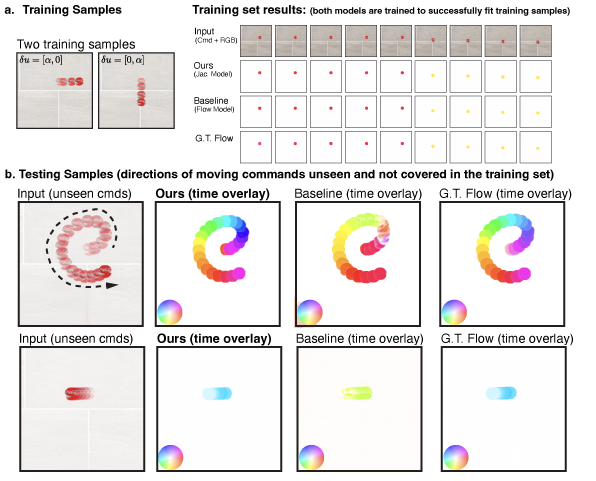

In [3]:
display.Image("PusherExample.png")

# 1. Loading Mujoco environment

In [4]:
overrides = []

map_to_sim_root = Path("../../mujoco-phys-sim")
config_path = Path("phys_sim/configurations/pusher_only.yaml")

with initialize(
    version_base=None, config_path=str(map_to_sim_root / config_path.parent)
):
    hydra_cfg = compose(
        config_name=str(config_path.name),
        overrides=overrides,
    )


env_cfg: PushEnvCfg = get_typed_root_config(hydra_cfg, PushEnvCfg)
env = PushEnv(env_cfg)

Loading input MjModel


""

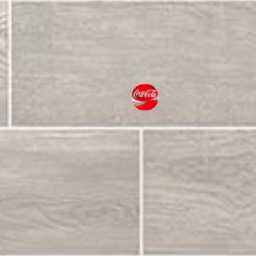

In [5]:
image = env.render("birdview")
media.show_image(image)

# 2. Rolling out dynamics to create a trajectory

To train our jacobian field, we need the following data pairs
- current observation: visual frame
- agent's action: the variation of robot's command, du
- perceptions of agent's action: visual optical flow

In the case of our pusher system, action is parameterized as the finite difference of agent's action between two timesteps. We will explain action parameterization in detail later. Stay tuned for now!


In [6]:
"""
could have used the existing demo,
but we will create one since I forgot to save the seg. mask.
"""

traj_video = []
traj_qpos = []


def get_obs(env):
    image = env.render("birdview")
    qpos = env.data.get_body_xpos(f"pusher_main").copy()

    traj_video.append(image)
    traj_qpos.append(qpos)


# take a photo fo the mask
env.reset()
init_seg_mask = env.render("birdview", render_segmentation=True)

# reset and generate a traj.
env.reset()
env.controller.interpolator.total_steps = 32 * 2

# position_based_command = np.array([0.0, 1.0])
position_based_command = np.array([0.0, -0.82])
horizon = 70
for i in range(horizon):
    env.step(position_based_command)

    if get_obs is not None:
        get_obs(env)

media.show_video(traj_video)

print(env.data.get_body_xpos(f"pusher_main").copy())
print(env.sim.data.get_joint_qpos("pusher_y_joint"))

[ 0.        -0.4599984  0.25     ]
-0.8199984102146461


In [7]:
device = "cuda:0"
raft = RaftWrapper()
raft = raft.eval()
raft.to(device)

RaftWrapper(
  (model): RAFT(
    (feature_encoder): FeatureEncoder(
      (convnormrelu): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
      (layer1): Sequential(
        (0): ResidualBlock(
          (convnormrelu1): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (2): ReLU(inplace=True)
          )
          (convnormrelu2): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (2): ReLU(inplace=True)
          )
          (downsample): Identity()
          (relu)

In [ ]:
"""Convert video to torch"""

traj_video_th = torch.from_numpy(np.stack(traj_video, axis=0))
traj_video_th = rearrange(traj_video_th, "t h w c -> t c h w").to(device)
traj_video_th = (traj_video_th / 255.0).float()
# it is empirically found that the model works better with longer dimension of 768
resized_video_th, (orig_H, orig_W) = resize_batched_frames(traj_video_th)

In [9]:
# processing in small batches to avoid GPU OOM, sliding window
num_frames = resized_video_th.shape[0]

# Initialize the parameters
window_size = 12
start = 0
end = num_frames

seq_flow_obs = []
for i in range(start, end, window_size - 1):
    window_start = i
    window_end = i + window_size
    window_end = min(window_end, end)

    mini_batch = resized_video_th[window_start:window_end].unsqueeze(0)

    with torch.no_grad():
        sbatch_pred_flows = raft.forward_flow(mini_batch, chunk=10)

    seq_flow_obs.append(sbatch_pred_flows)

seq_flow_obs = torch.cat(seq_flow_obs, dim=0)  # T - 1, 2, H, W

print(seq_flow_obs.shape)

torch.Size([69, 2, 768, 768])


In [ ]:
"""Visualize optical flow"""

# plot flow
seq_flow_vis_rgb = flow_to_image(seq_flow_obs)
# reshape to original height and width
seq_flow_vis_rgb = torch.nn.functional.interpolate(
    seq_flow_vis_rgb, (orig_H, orig_W)
)
seq_flow_vis_rgb = rearrange(seq_flow_vis_rgb, "t c h w -> t h w c")
seq_flow_vis_rgb = seq_flow_vis_rgb.cpu().numpy()

# concatenate the flow and the video side by side, trim the last frame of the video to match time length
vis_video = np.concatenate([np.array(traj_video[:-1]), seq_flow_vis_rgb], axis=2)
media.show_video(vis_video)
media.write_video("raft.mp4", vis_video)

# 3. Pack everything into functions and generate our training data

That's a quick walk through of our simulator. Let's now generate two trajectories: move-right and move-down.


Let's save our trajectory as a dictionary.


```python
class Trajectory(TypedDict):
    seq_rgb_obs: Float[np.ndarray, "num_steps height width channels"]
    seq_qpos: Float[np.ndarray, "num_steps command_dim"]
    seq_flow_obs: Float[np.ndarray, "num_steps 2 height width"]
```


In [39]:
from jacobian.utils.io import numpy_to_torch_image


def infer_seq_flow_obs(traj_video, window_size=12):

    traj_video_th = torch.stack([numpy_to_torch_image(x) for x in traj_video], dim=0)
    traj_video_th = traj_video_th.to(device)

    # it is empirically found that the model works better with longer dimension of 768
    resized_video_th, (orig_H, orig_W) = resize_batched_frames(traj_video_th)

    seq_flow_obs = []
    for i in tqdm.trange(
        0, len(traj_video_th), window_size - 1, desc="Infering Optical Flow"
    ):
        window_start = i
        window_end = i + window_size
        window_end = min(window_end, end)

        mini_batch = resized_video_th[window_start:window_end].unsqueeze(0)

        with torch.no_grad():
            sbatch_pred_flows = raft.forward_flow(mini_batch, chunk=10)

        seq_flow_obs.append(sbatch_pred_flows)

    seq_flow_obs = torch.cat(seq_flow_obs, dim=0)  # T - 1, 2, H, W

    # resize back to original shape, and scale the flow values correctly.
    seq_flow_obs = resize_batched_flow(seq_flow_obs, orig_H, orig_W)

    # reshape to original height and width
    seq_flow_vis_rgb = flow_to_image(seq_flow_obs)
    seq_flow_vis_rgb = torch.nn.functional.interpolate(
        seq_flow_vis_rgb, (orig_H, orig_W)
    )
    seq_flow_vis_rgb = rearrange(seq_flow_vis_rgb, "t c h w -> t h w c")
    seq_flow_vis_rgb = seq_flow_vis_rgb.cpu().numpy()

    return seq_flow_obs, seq_flow_vis_rgb

In [68]:
traj_video = []
traj_qpos = []
optical_flow_video = []


def get_obs(env):
    image = env.render("birdview")
    qpos = env.data.get_body_xpos(f"pusher_main").copy()

    traj_video.append(image)
    traj_qpos.append(qpos)


def clear_traj():
    traj_video.clear()
    traj_qpos.clear()


def save_traj(save_path: Path):
    # infer flow
    seq_flow_obs, seq_flow_vis_rgb = infer_seq_flow_obs(traj_video)
    seq_flow_obs = seq_flow_obs.cpu().numpy()

    global optical_flow_video
    optical_flow_video = seq_flow_vis_rgb

    assert len(traj_video) - 1 == len(traj_qpos) - 1 == len(seq_flow_obs)

    traj_dict = Trajectory(
        seq_rgb_obs=np.stack(traj_video[:-1], axis=0),
        seq_qpos=np.stack(traj_qpos[:-1], axis=0),
        seq_flow_obs=seq_flow_obs,
    )
    print(
        f"""Shape of tensors
            seq_rgb_obs: {traj_dict["seq_rgb_obs"].shape}
            seq_qpos: {traj_dict["seq_qpos"].shape}
            seq_flow_obs: {traj_dict["seq_flow_obs"].shape}
          """
    )

    save_gzip_file(traj_dict, save_path)


PusherTrajTypes = Literal["down", "right", "up", "left", "circle"]
Stage = Literal["train", "val", "test"]


def build_and_write_traj(
    write_dir: Path,
    traj_type: PusherTrajTypes,
    save_stages: List[Stage],
    horizon: int = 50,
):
    clear_traj()

    if traj_type == "down":
        env.down_traj(horizon=horizon, get_obs=get_obs)
    elif traj_type == "right":
        env.right_traj(horizon=horizon, get_obs=get_obs)
    elif traj_type == "up":
        env.up_traj(horizon=horizon, get_obs=get_obs)
    elif traj_type == "left":
        env.left_traj(horizon=horizon, get_obs=get_obs)
    elif traj_type == "angled":
        env.random_angled_traj(horizon=horizon, get_obs=get_obs)
    elif traj_type == "circle":
        env.circle_trajectory(horizon=horizon, get_obs=get_obs)

    for stage in save_stages:
        write_dir = write_dir / stage
        write_dir.mkdir(parents=True, exist_ok=True)
        write_filename = write_dir / f"{traj_type}.pkl"
        print(f"saving to path {write_filename}")
        save_traj(write_filename)
        print("done.")

In [70]:
### create data
map_to_root = Path("../..")
save_dir = map_to_root / "data/pusher_only"
# make dir if not existant
os.makedirs(save_dir, exist_ok=True)


clear_traj()
build_and_write_traj(save_dir, "down", ["train"], horizon=50)
media.show_videos([traj_video[:-1], optical_flow_video], fps=10)

clear_traj()
build_and_write_traj(save_dir, "right", ["train"], horizon=50)
media.show_videos([traj_video[:-1], optical_flow_video], fps=10)

clear_traj()
build_and_write_traj(save_dir, "circle", ["val"], horizon=50)
media.show_videos([traj_video[:-1], optical_flow_video], fps=10)


clear_traj()
build_and_write_traj(save_dir, "up", ["val"], horizon=50)
media.show_videos([traj_video[:-1], optical_flow_video], fps=10)

clear_traj()
build_and_write_traj(save_dir, "left", ["val"], horizon=50)
media.show_videos([traj_video[:-1], optical_flow_video], fps=10)

saving to path ../../data/pusher_only/train/down.pkl


Infering Optical Flow: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Shape of tensors
            seq_rgb_obs: (49, 256, 256, 3)
            seq_qpos: (49, 3)
            seq_flow_obs: (49, 2, 256, 256)
          
done.


saving to path ../../data/pusher_only/train/right.pkl


Infering Optical Flow: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Shape of tensors
            seq_rgb_obs: (49, 256, 256, 3)
            seq_qpos: (49, 3)
            seq_flow_obs: (49, 2, 256, 256)
          
done.


saving to path ../../data/pusher_only/val/circle.pkl


Infering Optical Flow: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Shape of tensors
            seq_rgb_obs: (49, 256, 256, 3)
            seq_qpos: (49, 3)
            seq_flow_obs: (49, 2, 256, 256)
          
done.


saving to path ../../data/pusher_only/val/up.pkl


Infering Optical Flow: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Shape of tensors
            seq_rgb_obs: (49, 256, 256, 3)
            seq_qpos: (49, 3)
            seq_flow_obs: (49, 2, 256, 256)
          
done.


saving to path ../../data/pusher_only/val/left.pkl


Infering Optical Flow: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Shape of tensors
            seq_rgb_obs: (49, 256, 256, 3)
            seq_qpos: (49, 3)
            seq_flow_obs: (49, 2, 256, 256)
          
done.


# 4. Training our jacobian field!

### A. Intuition
Let's train our 2D Jacobian fields. The idea is to explain away perceptual observations (image and optical flow) given an action (robot command). 

In other words, we are interested in the following inference question: "why is the world structured in a particular way at the current state such that my action is generating motions in this way?" 

### B. Method & Architecture
It is important to realize that in this case, the spatial domain of our physical system is naively modeled as the pixel locations in our image space.

We use a simple UNet that maps every pixel location to a Jacobian tensor (N_cmd x N_space).

### C. Important Notes
**[Wandb Setup]** Please setup the wandb information inside `project/jacobian/configurations/config.yaml` to be able to run the following training command.

**[Potential GPU OOM Error]**: RAFT inference might take too much memory on your machine. Please restart the notebook, run the first few cell for imports, and skip running all the RAFT-related cells.

### D. Training Commands
Running this script and train till convergence will give us the Jacobian fields!

```bash
conda activate neural-jacobian-field-public
python3 -m jacobian.train dataset=pusher_only wrapper=pusher_only wandb.mode=online wandb.name=pusher_only_jacobian 
```

### E. Training Speed
This script should be lightning fast to run. One validation step (500 gradient steps w/ Batch Size 12) should already provide convergence to the model.


## Loading trained model
After training, let's load up our trained model!

In [ ]:
import torch
import numpy as np

from jacobian.train import PipelineCfg
from jacobian.models.model_wrapper_base import get_wrapper

device = torch.device("cuda:0")

config_path = Path("project/jacobian/configurations/config.yaml")


checkpoint_path = "./tutorial_pretrained_ckpts/zidq6tgi/model.ckpt"
model_name_kwrd = "unet_jacobian"

overrides = [
    "dataset=pusher_only",
    "wrapper=pusher_only",
]


with initialize(version_base=None, config_path=str("../../" / config_path.parent)):
    hydra_cfg = compose(config_name=str(config_path.name), overrides=overrides)

cfg: PipelineCfg = get_typed_root_config(hydra_cfg, PipelineCfg)

wrapper = get_wrapper(cfg.wrapper)
model = wrapper.model

/home/scene-rep-robot/miniconda3/envs/neural-jacobian-field-public/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [ ]:
checkpoint = torch.load(checkpoint_path)

msg = wrapper.load_state_dict(checkpoint["state_dict"], strict=False)
print(msg)

wrapper.eval()
print("finished loading model")
wrapper.to(device)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


<All keys matched successfully>
finished loading model


PusherModelWrapper(
  (model): UnetJacobianField(
    (jacobian_field): UNet(
      (down_convs): ModuleList(
        (0): DownConv(
          (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): DownConv(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): DownConv(
          (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (up_convs): ModuleList(
        (0): UpConv(
          (upconv): ConvTranspose2

In [6]:
import torch
from jacobian.dataset.pusher_dataset import Trajectory, numpy_to_torch_image
from jacobian.utils.io import load_gzip_file

pusher_min_qpos = torch.tensor([-1.7, -1.09], dtype=torch.float32)[None]
pusher_max_qpos = torch.tensor([0.4, 1.0], dtype=torch.float32)[None]
action_scale: float = 4.0


def get_val_item(trajectory_path):

    trajectory: Trajectory = load_gzip_file(trajectory_path)

    input_video_sequence = trajectory["seq_rgb_obs"]
    joint_pos_sequence = torch.from_numpy(trajectory["seq_qpos"])
    joint_pos_sequence = joint_pos_sequence[..., :2]  # num_steps x command_dim

    traj_flow_sequence = torch.from_numpy(trajectory["seq_flow_obs"])

    # normalize the joint_pos sequence
    joint_pos_sequence = (joint_pos_sequence - pusher_min_qpos) / (
        pusher_max_qpos - pusher_min_qpos
    )

    input_video_sequence = torch.stack(
        [numpy_to_torch_image(img) for img in input_video_sequence], dim=0
    )

    # grab the current joint pos
    input_command_sequence = action_scale * (
        joint_pos_sequence[1:] - joint_pos_sequence[:-1]
    )

    return {
        "input_video_sequence": input_video_sequence.float(),
        "input_command_sequence": input_command_sequence.float(),
        "trgt_flow_sequence": traj_flow_sequence.float(),
    }

## Loading validation data

In [7]:
# visualize val samples

### create data
map_to_root = Path("../..")
save_dir = map_to_root / "data/pusher_only"
val_datafiles = list(Path(save_dir / "val").rglob("*.pkl"))

videos = []
video_titles = []
for i, datafile in enumerate(val_datafiles):
    data = load_gzip_file(datafile)
    images = data["seq_rgb_obs"]  # T H W C
    H, W = images.shape[1:3]
    videos.append(images)
    video_titles.append(datafile.name)


media.show_videos(videos, fps=10, height=H // (2), width=W // (2), titles=video_titles)

## Testing our model!

In [12]:
# print()

from einops import rearrange
from jacobian.models.model_wrapper_planar_hand import (
    compute_sensitivity,
    visualize_sensitivity,
)

for i, datafile in enumerate(val_datafiles):
    data_dict = get_val_item(datafile)

    # move data to device
    for k in data_dict.keys():
        data_dict[k] = data_dict[k].to(device)

    vis_outputs, total_flow_error = wrapper.visualize_model(
        input_video_sequence=data_dict["input_video_sequence"],
        input_command_sequence=data_dict["input_command_sequence"],
        trgt_flow_sequence=data_dict["trgt_flow_sequence"][:-1],
    )

    for k, v in vis_outputs.items():
        if k == "error":
            continue

        vis_outputs[k] = rearrange(vis_outputs[k], "t c h w -> t h w c")

    media.show_videos(
        [
            vis_outputs["video/input_video"],
            vis_outputs["video/ground_truth_optical_flow"],
            vis_outputs["video/pred_optical_flow"],
            vis_outputs["video/jacobian_q0"],
            vis_outputs["video/jacobian_q1"],
        ],
        titles=[
            "input_video",
            "ground_truth_optical_flow",
            "pred_optical_flow",
            "jacobian_q0",
            "jacobian_q1",
        ],
        fps=10,
    )
    print("Error", total_flow_error)

torch.Size([48, 2, 256, 256]) torch.Size([48, 2, 256, 256])


Error tensor(0.0392, device='cuda:0')
torch.Size([48, 2, 256, 256]) torch.Size([48, 2, 256, 256])


Error tensor(0.0032, device='cuda:0')
torch.Size([48, 2, 256, 256]) torch.Size([48, 2, 256, 256])


Error tensor(0.0036, device='cuda:0')


## Conclusion

Thank you for your attention! That concludes our first tutorial. Please post issues under our github repo or email sizheli@mit.edu for any suggestions / typos / questions. Thank you!
